# New York Yellow Taxi Predictions

### Import libraries

Importing all the neccessary libraries.

In [1]:
import pandas as pd
import dask.dataframe as dd#similar to pandas

# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

import warnings
warnings.filterwarnings("ignore")

# Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 January data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC).
</p>

## Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credit: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period between Jan - 2016.

# Data Collection
We have collected all yellow taxi trips data from jan-2016.

In [3]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
data_yt_month = dd.read_csv('yellow_tripdata_2016-01.csv')
print(data_yt_month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# Problem Statement
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups of given location cordinates(latitude and longitude) and time, in the query region and surrounding regions.</i>

<p> 
To solve the above we would be using collected data of January 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## Data Cleaning
In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error.  
The table below shows few datapoints along with all our features.

In [4]:
data_yt_month.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,40.763142,2,19.0,0.5,0.5,0.0,0.0,0.3,20.3
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,40.789871,2,26.0,0.5,0.5,0.0,0.0,0.3,27.3
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,40.753944,2,9.0,0.5,0.5,0.0,0.0,0.3,10.3
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,40.865578,2,18.0,0.5,0.5,0.0,0.0,0.3,19.3
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,40.688400,2,11.5,0.5,0.5,0.0,0.0,0.3,12.8


### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.  

In the given cell we are plotting pickup cordinates which are outside the bounding box of New-York city.  

Note: As you dont need indeepth knowledge on these maps and plots, you don't have to remember any of these.

In [5]:
# we will collect all the points outside the bounding box of newyork city to locations_of_outlier
locations_of_outlier = data_yt_month[((data_yt_month.pickup_longitude <= -74.15) | (data_yt_month.pickup_latitude <= 40.5774)| \
                   (data_yt_month.pickup_longitude >= -73.7004) | (data_yt_month.pickup_latitude >= 40.9176))]

# creating a map with the a base location
maps = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
locations_sample = locations_of_outlier.head(1000)
for i,j in locations_sample.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(maps)
maps

<b>Observation:-</b> As you can see above that there are some points just outside the boundary.

## 2. Dropoff Latitude and Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.  

Plotting dropoff cordinates which are outside the bounding box of New-York. 

In [6]:
# we will collect all the points outside the bounding box of newyork city to locations_of_outlier
locations_of_outlier = data_yt_month[((data_yt_month.dropoff_longitude <= -74.15) | (data_yt_month.dropoff_latitude <= 40.5774)| \
                   (data_yt_month.dropoff_longitude >= -73.7004) | (data_yt_month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
maps = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
locations_sample = locations_of_outlier.head(1000)
for i,j in locations_sample.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(maps)
maps

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>  

In the cell below the timestamps are converted to unix. Also to get duration(trip-time) and speed, pickup-times in unix are used while binning.  

We are returning a data frame which contains the following columns:  
1.'passenger_count' : self explanatory  
2.'trip_distance' : self explanatory  
3.'pickup_longitude' : self explanatory  
4.'pickup_latitude' : self explanatory  
5.'dropoff_longitude' : self explanatory  
6.'dropoff_latitude' : self explanatory  
7.'total_amount' : total fair that was paid  
8.'trip_times' : duration of each trip  
9.'pickup_times : pickup time converted into unix time   
10.'Speed' : velocity of each trip  

In [7]:
# in our data we have time in the format "YYYY-MM-DD HH:MM:SS" we convert this string to python time format and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(data_yt_month):
    duration = data_yt_month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    pickupduration = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    dropoffduration = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    #calculate duration of trips
    calc_durations = (np.array(dropoffduration) - np.array(pickupduration))/float(60)
    
    #append durations of trips and speed in miles/hr to a new dataframe
    yt = data_yt_month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    yt['trip_times'] = calc_durations
    yt['pickup_times'] = pickupduration
    yt['Speed'] = 60*(yt['trip_distance']/yt['trip_times'])
    
    return yt
new_df_duration = return_with_trip_times(data_yt_month)
# print(new_df_duration)

# #        passenger_count  trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  total_amount  trip_times  pickup_times  speed
# 0                     2           1.10        -73.990372        40.734695      -73.981842         40.732407          8.80       0.000000   1.451567e+09   inf
# 1                     5           4.90        -73.980782        40.729912      -73.944473         40.716679         19.30       0.000000   1.451567e+09   inf
# 2                     1          10.54        -73.984550        40.679565      -73.950272         40.788925         34.30       0.000000   1.451567e+09   inf
# 3                     1           4.75        -73.993469        40.718990      -73.962242         40.657333         17.30       0.000000   1.451567e+09   inf
# 4                     3           1.76        -73.960625        40.781330      -73.977264         40.758514          8.80       0.000000   1.451567e+09   inf

The skewed box plot shows us the presence of outliers 

<IPython.core.display.Javascript object>


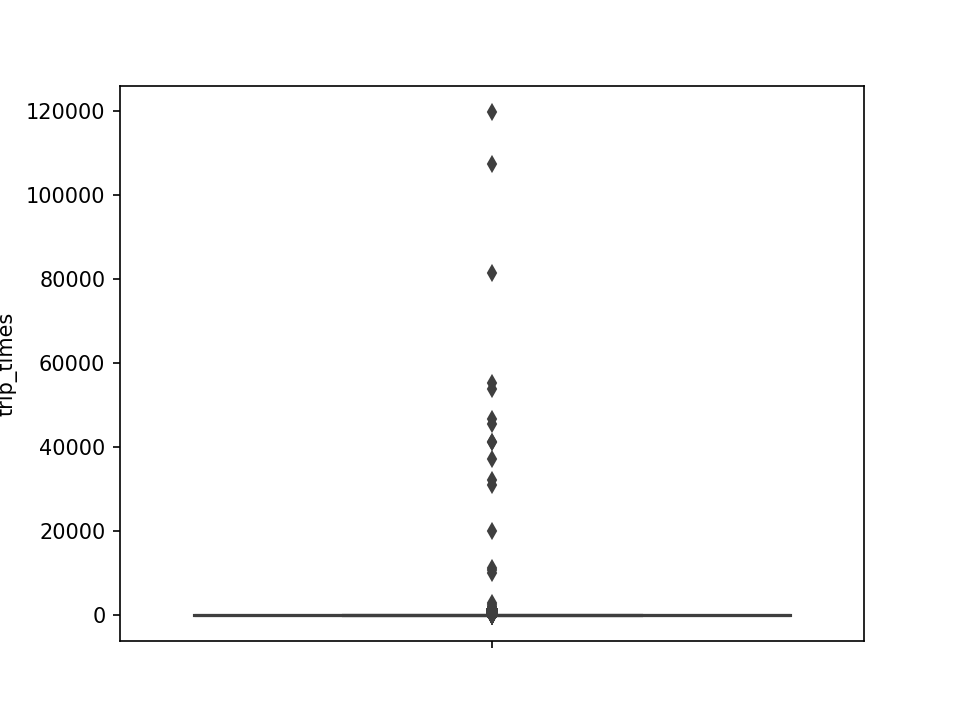

In [8]:
sns.boxplot(y="trip_times", data =new_df_duration)
plt.show()

To find the correct percentile value for removal of outliers 0-100th percentile is calculated

In [9]:
for i in range(0,100,10):
    p_var =new_df_duration["trip_times"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print ("100 percentile value is ",p_var[-1])

0 percentile value is -43.95
10 percentile value is 3.933333333333333
20 percentile value is 5.566666666666666
30 percentile value is 7.1
40 percentile value is 8.683333333333334
50 percentile value is 10.466666666666667
60 percentile value is 12.55
70 percentile value is 15.2
80 percentile value is 18.933333333333334
90 percentile value is 25.516666666666666
100 percentile value is  119912.7


Here, we are looking further from the 99th percentile

In [10]:
for i in range(90,100):
    p_var =new_df_duration["trip_times"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print ("100 percentile value is ",p_var[-1])

90 percentile value is 25.516666666666666
91 percentile value is 26.55
92 percentile value is 27.733333333333334
93 percentile value is 29.116666666666667
94 percentile value is 30.733333333333334
95 percentile value is 32.7
96 percentile value is 35.233333333333334
97 percentile value is 38.666666666666664
98 percentile value is 43.916666666666664
99 percentile value is 53.9
100 percentile value is  119912.7


Removing data based on our analysis and TLC regulations

In [11]:
modified_new_df_duration=new_df_duration[(new_df_duration.trip_times>1) & (new_df_duration.trip_times<720)]

Below is the box-plot after removal of outliers

<IPython.core.display.Javascript object>


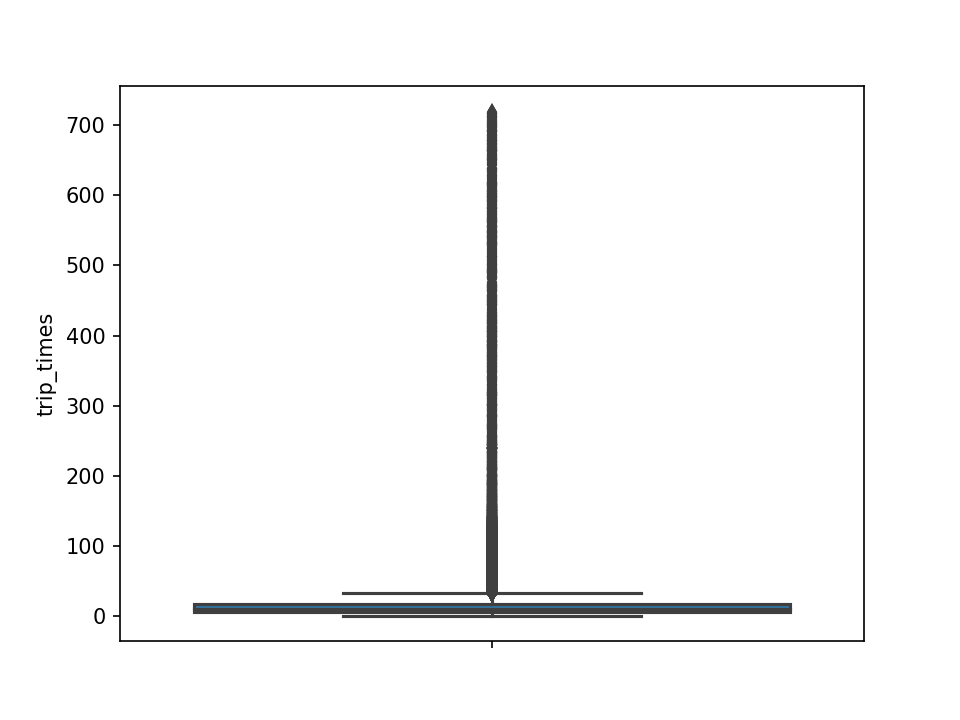

In [12]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =modified_new_df_duration)
plt.show()

Pdf of trip-times after removing the outliers

<IPython.core.display.Javascript object>


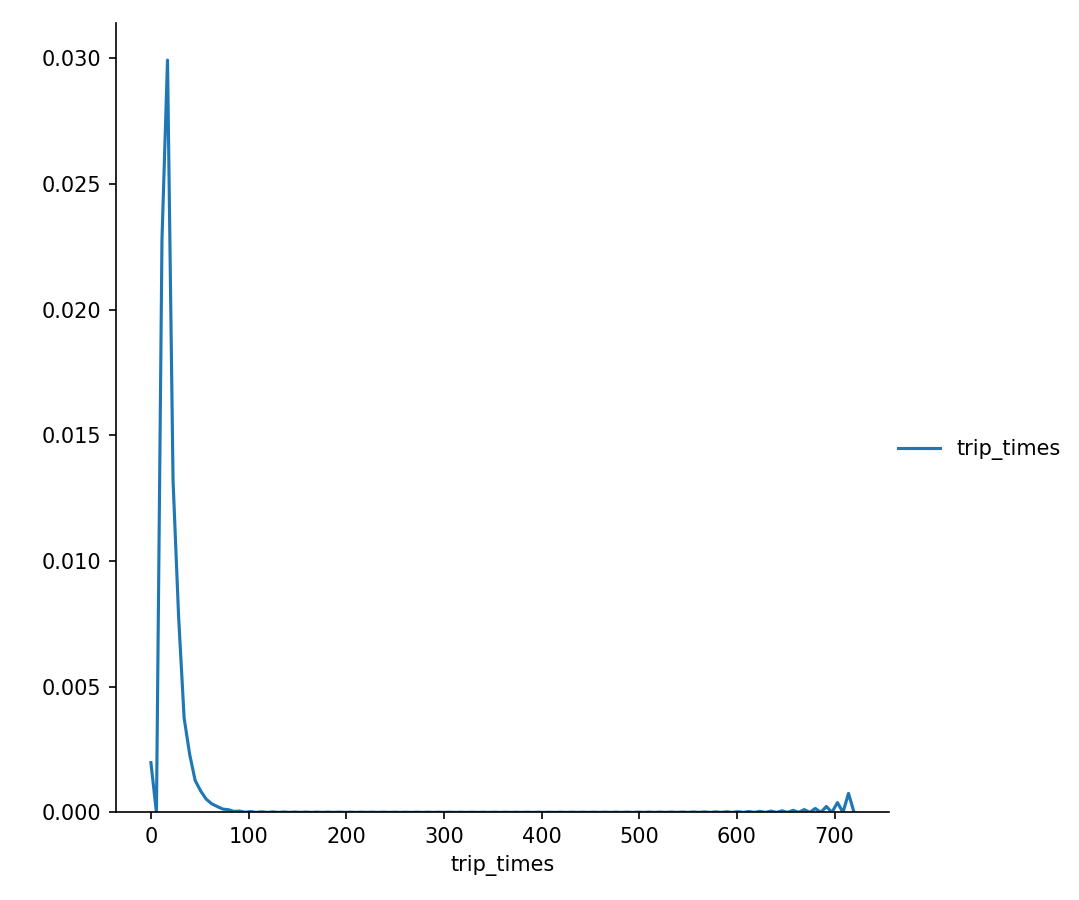

In [13]:
sns.FacetGrid(modified_new_df_duration,height=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

Converting the values to log-values to check for log-normal

In [16]:
import math
modified_new_df_duration['log_times']=[math.log(i) for i in modified_new_df_duration['trip_times'].values]

Pdf of log-values

<IPython.core.display.Javascript object>


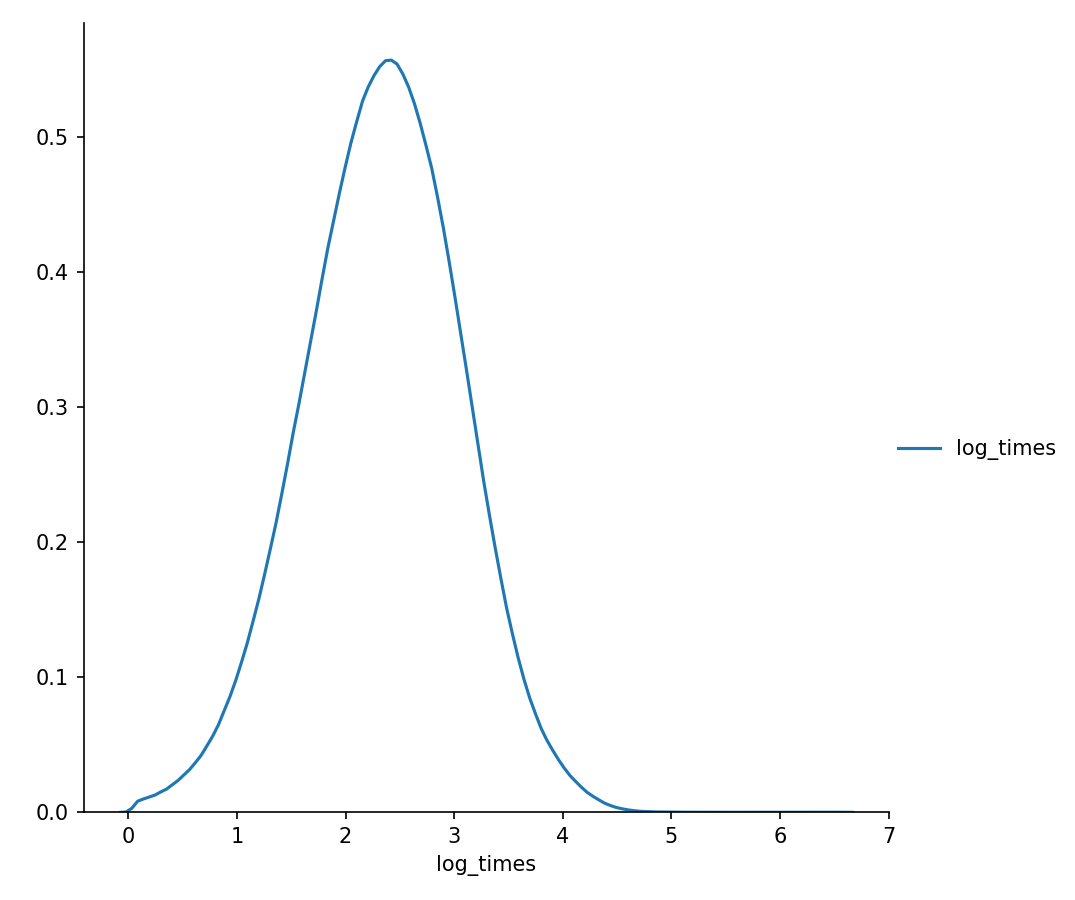

In [17]:
sns.FacetGrid(modified_new_df_duration,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

### 4. Speed

Here, we are checking if there are any outliers in the data after trip duration outliers are removed and you can also see box-plot for speed with outliers

<IPython.core.display.Javascript object>


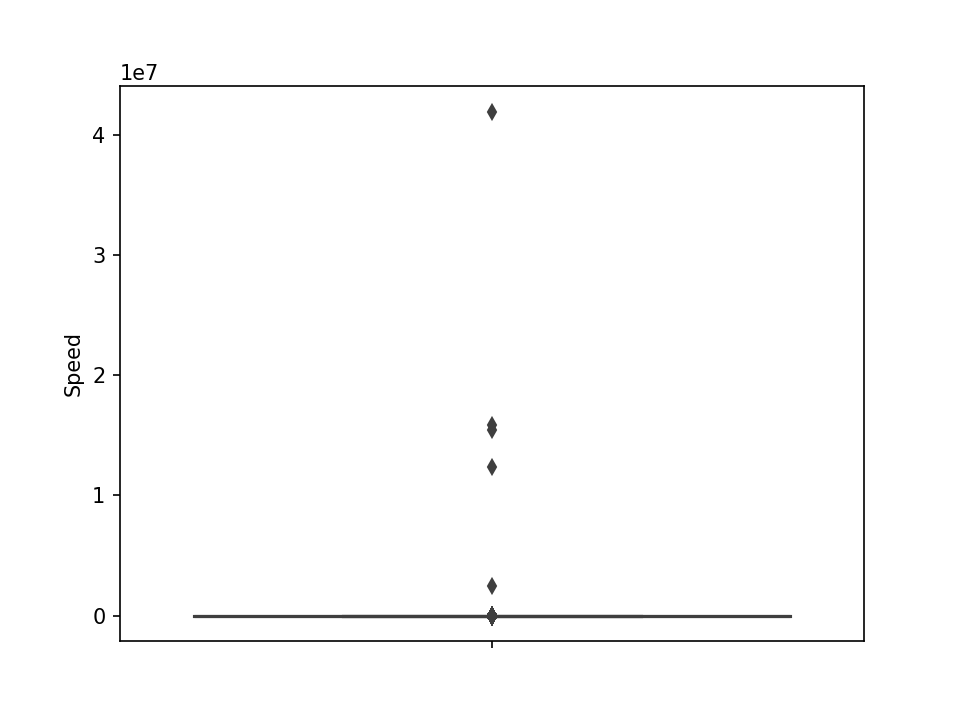

In [18]:
modified_new_df_duration['Speed'] = 60*(modified_new_df_duration['trip_distance']/modified_new_df_duration['trip_times'])
sns.boxplot(y="Speed", data =modified_new_df_duration)
plt.show()

In [19]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    p_var =modified_new_df_duration["Speed"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print("100 percentile value is ",p_var[-1])

0 percentile value is 0.0
10 percentile value is 6.011787819253438
20 percentile value is 7.390029325513196
30 percentile value is 8.49689440993789
40 percentile value is 9.545454545454543
50 percentile value is 10.638522427440636
60 percentile value is 11.87948350071736
70 percentile value is 13.432835820895523
80 percentile value is 15.6734693877551
90 percentile value is 20.035906642728904
100 percentile value is  41917233.8028169


In [20]:
#calculating speed values at each percentile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    p_var =modified_new_df_duration["Speed"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print("100 percentile value is ",p_var[-1])

90 percentile value is 20.035906642728904
91 percentile value is 20.77922077922078
92 percentile value is 21.62544169611307
93 percentile value is 22.594142259414227
94 percentile value is 23.720930232558143
95 percentile value is 25.043478260869566
96 percentile value is 26.641366223908914
97 percentile value is 28.652097902097903
98 percentile value is 31.304347826086957
99 percentile value is 35.33428165007113
100 percentile value is  41917233.8028169


In [21]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    p_var =modified_new_df_duration["Speed"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(99+i,p_var[int(len(p_var)*(float(99+i)/100))]))
print("100 percentile value is ",p_var[-1])

99.0 percentile value is 35.33428165007113
99.1 percentile value is 35.89123867069487
99.2 percentile value is 36.49769585253456
99.3 percentile value is 37.17507418397626
99.4 percentile value is 37.91878172588833
99.5 percentile value is 38.762376237623755
99.6 percentile value is 39.768642447418735
99.7 percentile value is 41.019230769230774
99.8 percentile value is 42.63212435233161
99.9 percentile value is 45.163636363636364
100 percentile value is  41917233.8028169


Removing further outliers based on the 99.9th percentile value

In [22]:
modified_new_df_duration=new_df_duration[(new_df_duration.Speed>0) & (new_df_duration.Speed<45.31)]

In [23]:
#avg.speed of cabs in New-York
sum(modified_new_df_duration["Speed"]) / float(len(modified_new_df_duration["Speed"]))

12.07876826004524

<b style='font-size:16px'>The average speed in Newyork speed is 12.07miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on average.</font> </b>

### 5. Trip Distance

Up to now we have removed the outliers based on trip durations and cab speeds. Now again, lets try if there are any outliers in trip distances.  
Box-plot can be seen showing outliers in trip-distance values

<IPython.core.display.Javascript object>


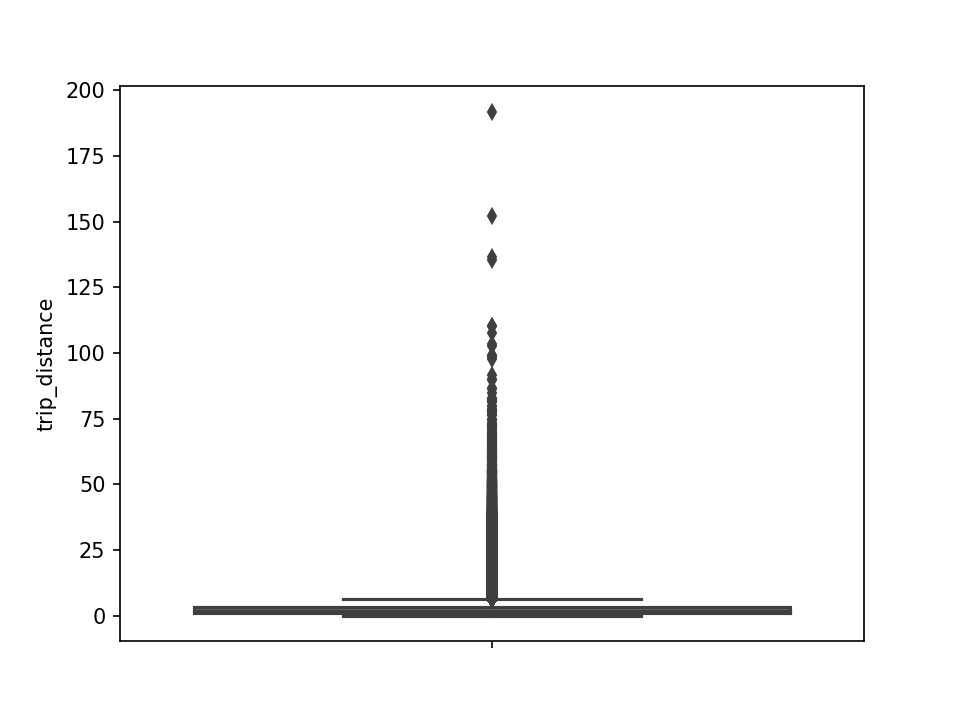

In [24]:
sns.boxplot(y="trip_distance", data =modified_new_df_duration)
plt.show()

In [25]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    p_var =modified_new_df_duration["trip_distance"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print("100 percentile value is ",p_var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.38
50 percentile value is 1.69
60 percentile value is 2.08
70 percentile value is 2.65
80 percentile value is 3.7
90 percentile value is 6.5
100 percentile value is  191.9


In [26]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    p_var =modified_new_df_duration["trip_distance"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print("100 percentile value is ",p_var[-1])

90 percentile value is 6.5
91 percentile value is 7.1
92 percentile value is 7.89
93 percentile value is 8.7
94 percentile value is 9.48
95 percentile value is 10.3
96 percentile value is 11.4
97 percentile value is 13.5
98 percentile value is 16.98
99 percentile value is 18.6
100 percentile value is  191.9


In [27]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    p_var =modified_new_df_duration["trip_distance"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(99+i,p_var[int(len(p_var)*(float(99+i)/100))]))
print("100 percentile value is ",p_var[-1])

99.0 percentile value is 18.6
99.1 percentile value is 18.8
99.2 percentile value is 19.02
99.3 percentile value is 19.3
99.4 percentile value is 19.61
99.5 percentile value is 20.01
99.6 percentile value is 20.5
99.7 percentile value is 21.01
99.8 percentile value is 21.79
99.9 percentile value is 23.9
100 percentile value is  191.9


In [28]:
#removing further outliers based on the 99.9th percentile value
modified_new_df_duration=new_df_duration[(new_df_duration.trip_distance>0) & (new_df_duration.trip_distance<23)]

Box-plot after removal of outliers

<IPython.core.display.Javascript object>


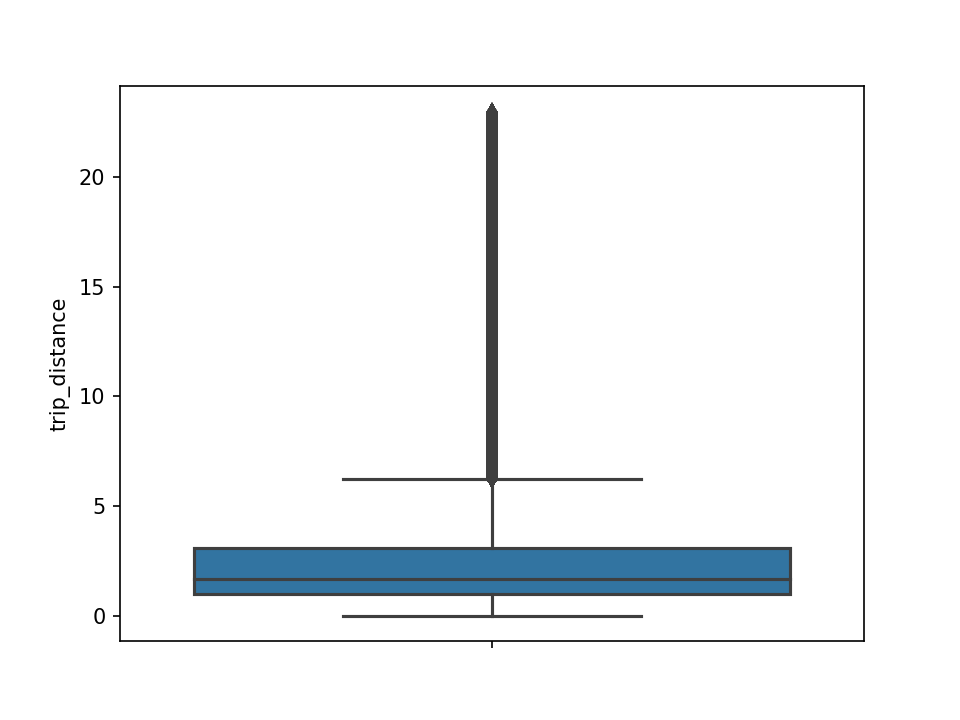

In [29]:
sns.boxplot(y="trip_distance", data = modified_new_df_duration)
plt.show()

### 6. Total Fare

Up to now we have removed the outliers based on trip durations, cab speeds, and trip distances.Now again, lets try if there are any outliers is based on the total_amount.  

Box-plot showing outliers in fare

<IPython.core.display.Javascript object>


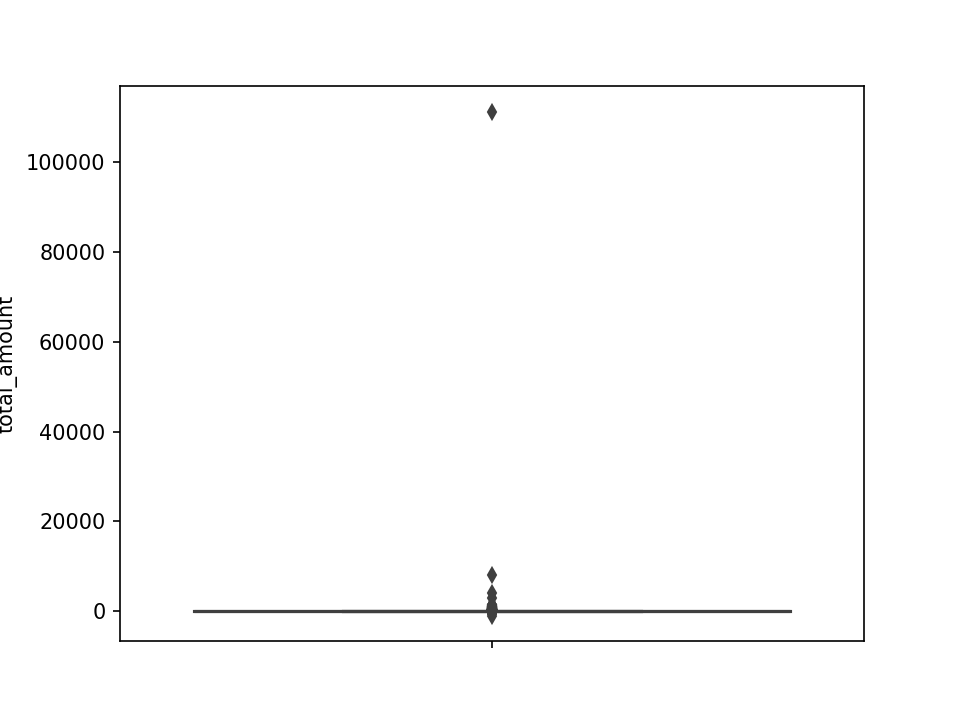

In [30]:
sns.boxplot(y="total_amount", data =modified_new_df_duration)
plt.show()

In [31]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    p_var = modified_new_df_duration["total_amount"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print("100 percentile value is ",p_var[-1])

0 percentile value is -958.4
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 10.3
50 percentile value is 11.62
60 percentile value is 13.3
70 percentile value is 15.36
80 percentile value is 19.24
90 percentile value is 27.96
100 percentile value is  111271.65


In [32]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    p_var = modified_new_df_duration["total_amount"].values
    p_var = np.sort(p_var,axis = None)
    print("{} percentile value is {}".format(i,p_var[int(len(p_var)*(float(i)/100))]))
print("100 percentile value is ",p_var[-1])

90 percentile value is 27.96
91 percentile value is 29.84
92 percentile value is 32.3
93 percentile value is 35.34
94 percentile value is 38.8
95 percentile value is 42.34
96 percentile value is 46.61
97 percentile value is 52.8
98 percentile value is 58.55
99 percentile value is 69.99
100 percentile value is  111271.65


<b>Observation:-</b> As even the 99.9th percentile value doesn't look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile therefore, we move on to do graphical analysis.

Below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers

<IPython.core.display.Javascript object>


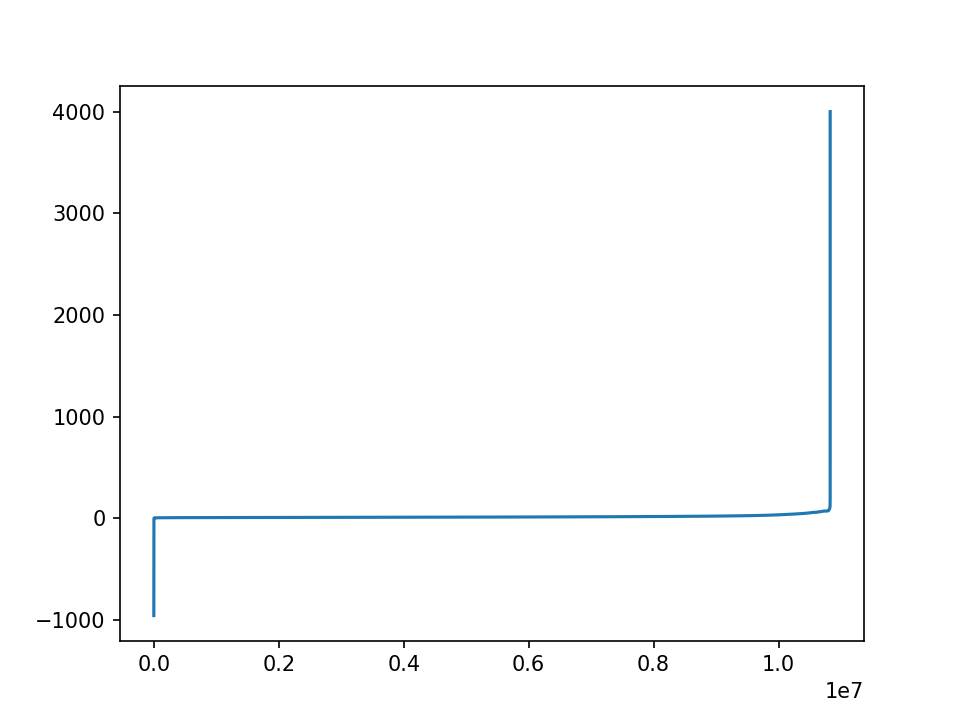

In [33]:
# plot the fare amount excluding last two values in sorted data
plt.plot(p_var[:-2])
plt.show()

A very sharp increase in fare values can be seen in the plot below.

<IPython.core.display.Javascript object>


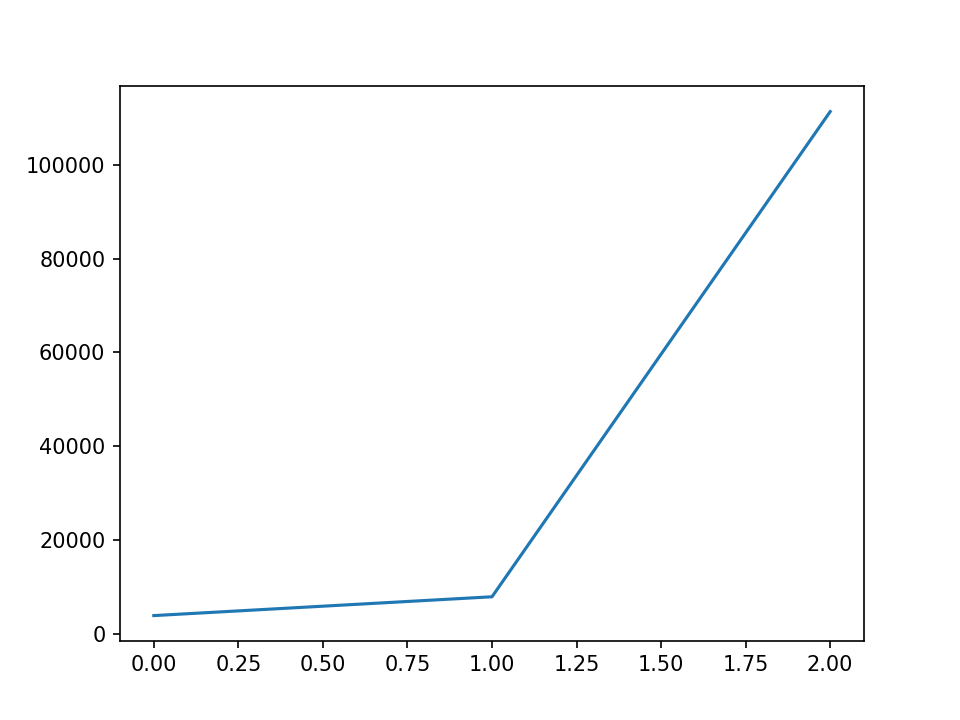

In [34]:
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(p_var[-3:])
plt.show()

Now by looking at values not including the last two points, we again find a drastic increase at around 1000 fare value

<IPython.core.display.Javascript object>


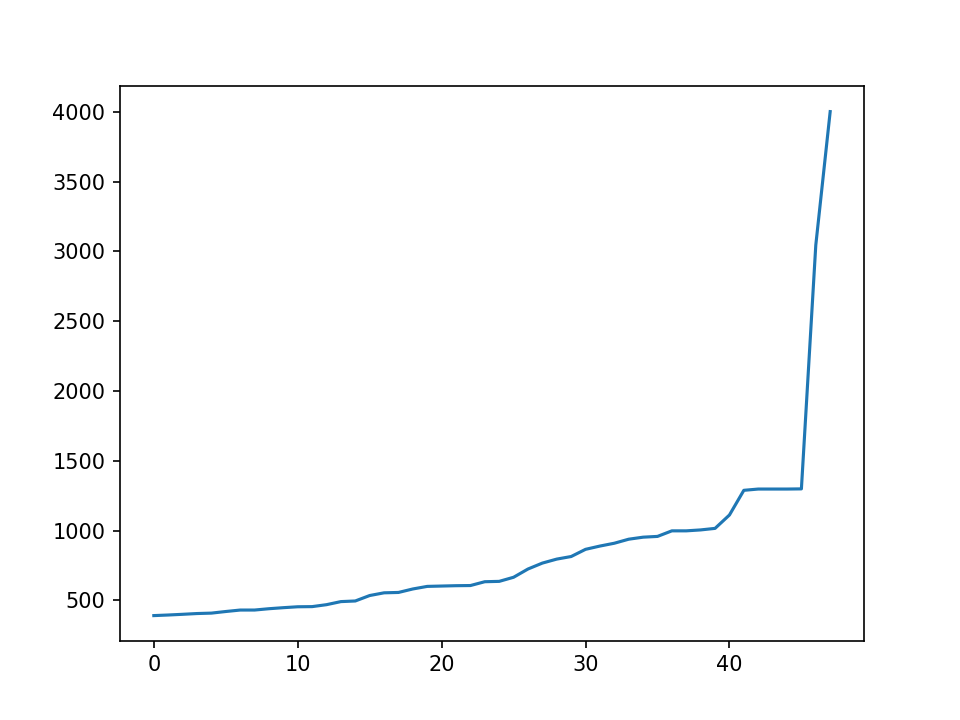

In [35]:
# we plot last 50 values excluding last two values
plt.plot(p_var[-50:-2])
plt.show()

## Remove all outliers/erroneous points.  

Removing all outliers based on our univariate analysis above

In [37]:
def remove_outliers(yt):

    
    a = yt.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = yt[((yt.dropoff_longitude >= -74.15) & (yt.dropoff_longitude <= -73.7004) &\
                       (yt.dropoff_latitude >= 40.5774) & (yt.dropoff_latitude <= 40.9176)) & \
                       ((yt.pickup_longitude >= -74.15) & (yt.pickup_latitude >= 40.5774)& \
                       (yt.pickup_longitude <= -73.7004) & (yt.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = yt[(yt.trip_times > 0) & (yt.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = yt[(yt.trip_distance > 0) & (yt.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = yt[(yt.Speed <= 65) & (yt.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = yt[(yt.total_amount <1000) & (yt.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    yt = yt[((yt.dropoff_longitude >= -74.15) & (yt.dropoff_longitude <= -73.7004) &\
             (yt.dropoff_latitude >= 40.5774) & (yt.dropoff_latitude <= 40.9176)) & \
             ((yt.pickup_longitude >= -74.15) & (yt.pickup_latitude >= 40.5774)& \
             (yt.pickup_longitude <= -73.7004) & (yt.pickup_latitude <= 40.9176))]
    
    yt = yt[(yt.trip_times > 0) & (yt.trip_times < 720)]
    yt = yt[(yt.trip_distance > 0) & (yt.trip_distance < 23)]
    yt = yt[(yt.Speed < 45.31) & (yt.Speed > 0)]
    yt = yt[(yt.total_amount <1000) & (yt.total_amount >0)]
    
    print ("Total outliers removed",a - yt.shape[0])
    print ("---")
    return yt

In [38]:
print ("Removing outliers in the month of Jan-2016")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(modified_new_df_duration)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(modified_new_df_duration))

Removing outliers in the month of Jan-2016
----
Number of pickup records =  10827116
Number of outlier coordinates lying outside NY boundaries: 184036
Number of outliers from trip times analysis: 15978
Number of outliers from trip distance analysis: 0
Number of outliers from speed analysis: 9654
Number of outliers from fare analysis: 3381
Total outliers removed 218042
---
fraction of data points that remain after removing outliers 0.9798614885071888


# Data-preperation

In this project data preparation is consist of two, CLUSTERING/SEGMENTATION and TIME-BINNING.

## Clustering/Segmentation

HHere for clustering we are using K-means clustering method.

In [39]:
#trying different cluster sizes to choose the right K in K-means
coordinates = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def finding_min_distance(cluster_centers, cluster_length ):
    good_points = 0
    bad_points = 0
    lesser = []
    greater = []
    minimum_distance=1000
    for i in range(0, cluster_length):
        good_points = 0
        bad_points = 0
        for j in range(0, cluster_length):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                minimum_distance = min(minimum_distance,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    good_points +=1
                else:
                    bad_points += 1
        lesser.append(good_points)
        greater.append(bad_points)
    neighbours.append(lesser)
    print ("On choosing a cluster size of ",cluster_length,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(lesser)/len(lesser)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(greater)/len(greater)),"\nMin inter-cluster distance = ",minimum_distance,"\n---")

def finding_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coordinates)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_length = len(cluster_centers)
    return cluster_centers, cluster_length

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_length = finding_clusters(increment)
    finding_min_distance(cluster_centers, cluster_length)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.9866648594955189 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.615204165728254 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.5463175334037668 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance =

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [41]:
# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coordinates)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [42]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_length = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_length):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

Visualising the clusters on a map

<IPython.core.display.Javascript object>


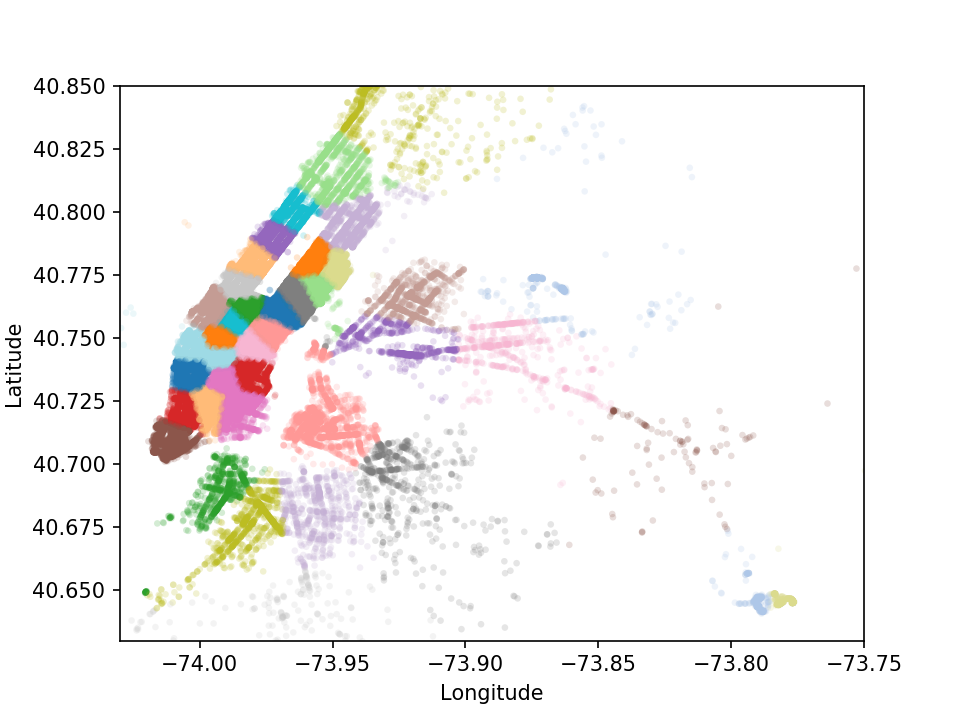

In [43]:
def plot_clusters(frame):
    city_longitude_border = (-74.03, -73.75)
    city_latitude_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_longitude_border)
    ax.set_ylim(city_latitude_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning

Refer:https://www.unixtimestamp.com/  

In [95]:
#1420070400 : 2015-01-01 00:00:00   
#1422748800 : 2015-02-01 00:00:00   
#1425168000 : 2015-03-01 00:00:00  
#1427846400 : 2015-04-01 00:00:00   
#1430438400 : 2015-05-01 00:00:00   
#1433116800 : 2015-06-01 00:00:00  

#1451606400 : 2016-01-01 00:00:00   
#1454284800 : 2016-02-01 00:00:00   
#1456790400 : 2016-03-01 00:00:00  
#1459468800 : 2016-04-01 00:00:00   
#1462060800 : 2016-05-01 00:00:00   
#1464739200 : 2016-06-01 00:00:00  
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

Clustering, making pickup bins and grouping by pickup cluster and pickup bins

In [96]:
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2016_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2016)
jan_2016_groupby = jan_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

Now, we add two more columns 'pickup_cluster'(to which cluster it belongs to)and 'pickup_bins' (to which 10min interval the trip belongs to)

In [97]:
jan_2016_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.50,1.451567e+09,17.902703,27,-33
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.75,1.451567e+09,16.710280,6,-33
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.90,1.451567e+09,6.050420,27,-32
8,1,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.20,1.451567e+09,32.142857,18,-32
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.10,1.451567e+09,17.351351,6,-32


Here,the trip_distance represents the number of pickups that are happened in that particular 10min interval.This data frame has two indices primary index: pickup_cluster (cluster number)and secondary index : pickup_bins (we divide whole months time into 10min intervals 24*31*60/10 =4464bins).

In [98]:
jan_2016_groupby

trip_distance
pickup_cluster pickup_bins               
0              -32                    183
               -31                    265
               -30                    288
               -29                    248
               -28                    210
...                                   ...
39              4426                   72
                4427                   55
                4428                   42
                4429                   48
                4430                   38

[169239 rows x 1 columns]

Upto now we cleaned data and prepared data for the month 2016.
Now do the same operations for months Jan, Feb, March of 2016
 1. get the dataframe which inlcudes only required colums
 2. adding trip times, speed, unix time stamp of pickup_time
 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
 5. add pickup_cluster to each data point
 6. add pickup_bin (index of 10min interval to which that trip belongs to)
 7. group by data, based on 'pickup_cluster' and 'pickup_bin'

In [48]:
# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
#month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
#month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
#feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
#mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..


# Smoothing

Gets the unique bins where pickup values are present for each each region.  
For each cluster region we will collect all the indices of 10min intervals in which the pickups are happened,
we got an observation that there are some pickupbins that doesnt have any pickups.

In [49]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

For every month we get all indices of 10min intervals in which atleast one pickup got happened

In [50]:
#jan
#jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
january_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
#feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
#mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [51]:
# for each cluster number of 10min intervals with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intervals with zero pickups: ",4464 - len(set(january_2016_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intervals with zero pickups:  81
------------------------------------------------------------
for the  1 th cluster number of 10min intervals with zero pickups:  72
------------------------------------------------------------
for the  2 th cluster number of 10min intervals with zero pickups:  596
------------------------------------------------------------
for the  3 th cluster number of 10min intervals with zero pickups:  424
------------------------------------------------------------
for the  4 th cluster number of 10min intervals with zero pickups:  86
------------------------------------------------------------
for the  5 th cluster number of 10min intervals with zero pickups:  81
------------------------------------------------------------
for the  6 th cluster number of 10min intervals with zero pickups:  83
------------------------------------------------------------
for the  7 th cluster number of 10min intervals with zero pickups:  86
---

Fills a value of zero for every bin where no pickup data is present   
the count_values: number pickps that are happened in each region for each 10min interval there wont be any value if there are no picksups.  
values: number of unique bins

For every 10min interval(pickup_bin) we will check if it is there in our unique bin, if it is there we will add the count_values[index] to smoothed data if not we add 0 to the smoothed data we finally return smoothed data.

In [52]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [53]:
# for every 10min interval(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


Filling Missing values of Jan-2016 with 0

In [54]:
january_2016_smooth = smoothing(jan_2016_groupby['trip_distance'].values,january_2016_unique)

In [55]:
january_2016_fill = fill_missing(jan_2016_groupby['trip_distance'].values,january_2016_unique)


In [56]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min interval among all the clusters ",len(january_2016_fill))

number of 10min interval among all the clusters  178560


In [57]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
data_jan = pd.DataFrame()
#ratios_jan['Given']=jan_2015_smooth
data_jan['2016']=january_2016_smooth
#ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [58]:
data_jan

,2016
0,183
1,265
2,288
3,248
4,210
...,...
178555,5
178556,5
178557,5
178558,5


## Modelling: Baseline Models
### Prediction using Moving Averages

This is a forecasting technique that helps to forecast the future value based on the average of past value. Number of past values to be considered based on the window size that acts as the hyper parameter for this technique. 

In [59]:
def MA_Predictions(data,month):
    print(" We predict the values based on the {} month".format(month))
    predicted_value=(data['2016'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(data['2016'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((data['2016'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((data['2016'].values)[0:(i+1)])/(i+1))
            
    data['MA_Predicted'] = predicted_values
    data['MA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(data['2016'].values)/len(data['2016'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return data,mape_err,mse_err

Here from the data we predict the future values based on the average of past values this gives equal importance to every value of the prediction.
### Prediction using Weighted Moving Averages
As in previous model we predicted the values based on past values now we predict by giving importance to the recent value that we do giving weights.

In [60]:
def WA_Predictions(data,month):
    print("we predict the values based on {} month".format(month))
    predicted_value=(data['2016'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(data['2016'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(data['2016'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(data['2016'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    data['WA_Predicted'] = predicted_values
    data['WA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(data['2016'].values)/len(data['2016'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return data,mape_err,mse_err

### Prediction using Exponential Moving Averages

Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

In [61]:
def EA_Predictions(data,month):
    predicted_value= (data['2016'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(data['2016'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((data['2016'].values)[i]))
    
    data['EA_Predicted'] = predicted_values
    data['EA_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(data['2016'].values)/len(data['2016'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return data,mape_err,mse_err

In [62]:
mean_err=[0]*10
median_err=[0]*10
#ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
data_jan,mean_err[0],median_err[0]=MA_Predictions(data_jan,'jan')
#ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
data_jan,mean_err[1],median_err[1]=WA_Predictions(data_jan,'jan')
#ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
data_jan,mean_err[2],median_err[2]=EA_Predictions(data_jan,'jan')

 We predict the values based on the jan month
we predict the values based on jan month


In [63]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
#print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[0],"       MSE: ",median_err[0])
print ("--------------------------------------------------------------------------------------------------------")
#print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[1],"      MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
#print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[2],"      MSE: ",median_err[2])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (2016 Values) -                        MAPE:  0.14151123847812141        MSE:  187.37342069892472
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (2016 Values) -               MAPE:  0.1355458534546717       MSE:  176.44737903225806
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (2016 Values) -         MAPE:  0.1355865429553735       MSE:  174.27628808243728


From this we can conclude that Exponential moving averages found that they gave less MAPE and MSE. So we consider Exponential moving averages as the basic baseline model.

Next we compute regression models our aim is to find out best model with MAPE less than 0.1356


## Modelling: Regression 
Here we execute a regression model based by adding some extra features to the above baseline model. Here we picked the best model that gave minimum error and add some extra time series features to it such that we can reduce the error of the plot.

### Train-test split

In every modelling we should divide the data to train and test. Here for modelling purposes we divide the code train and test bas per dates. Use first 70% of the data for training purposes and next 30% of the data for testing purposes.

In [64]:
regions = []
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# regions: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for January month in 2016 data

for i in range(0,40):
    regions.append(january_2016_smooth[4464*i:4464*(i+1)])

First we prepare to split the data, for this we use last five pickup bin and use them to predict the future. Based on the last five pickup bins we will find a exponential average of those and add them to as features.

In [65]:
time_stamps = 5
output = []
lat = []
long = []

weekday = []
features = []
features = [0]*time_stamps
for i in range(0, 40):
    lat.append([kmeans.cluster_centers_[i][0]]*4459) #4459 because we used 5 pick up bins as features: 4464-5 = 4459
    long.append([kmeans.cluster_centers_[i][1]]*4459)
    # we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    weekday.append([int(((int(b/144))%7+4)%7) for b in range(5,4464)])
    # we add 7 pick up bins
    features = np.vstack((features, [regions[i][r:r+time_stamps] for r in range(0,len(regions[i])-time_stamps)]))
    output.append(regions[i][5:])
features = features[1:]

In [66]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min interval
# 5. f_t_2: number of pickups that are happened previous t-2th 10min interval
# 6. f_t_3: number of pickups that are happened previous t-3th 10min interval
# 7. f_t_4: number of pickups that are happened previous t-4th 10min interval
# 8. f_t_5: number of pickups that are happened previous t-5th 10min interval

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min interval, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
EA_list = []

for r in range(0,40):
    for i in range(0,4464):
        if i==0:
            predicted_value= regions[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions[r][i]))
    EA_list.append(predicted_values[5:])
    predicted_values=[]

In [67]:
print("size of train data :", int(4459*0.7))
print("size of test data :", int(4459*0.3))

size of train data : 3121
size of test data : 1337


In [68]:
train_features =  [features[i*4459:(4459*i+3121)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [features[(4459*(i))+3121:4459*(i+1)] for i in range(0,40)]

In [69]:
train_lat = [i[:3121] for i in lat]
train_lon = [i[:3121] for i in long]
train_weekday = [i[:3121] for i in weekday]
train_output = [i[:3121] for i in output]
train_exp_avg = [i[:3121] for i in EA_list]

In [70]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
test_lat = [i[3121:] for i in lat]
test_lon = [i[3121:] for i in long]
test_weekday = [i[3121:] for i in weekday]
test_output = [i[3121:] for i in output]
test_exp_avg = [i[3121:] for i in EA_list]

In [71]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [72]:
f_train_lat = sum(train_lat, [])
f_train_lon = sum(train_lon, [])
f_train_weekday = sum(train_weekday, [])
f_train_output = sum(train_output, [])
f_train_exp_avg = sum(train_exp_avg,[])

In [73]:
f_test_lat = sum(test_lat, [])
f_test_lon = sum(test_lon, [])
f_test_weekday = sum(test_weekday, [])
f_test_output = sum(test_output, [])
f_test_exp_avg = sum(test_exp_avg,[])

In [74]:
amplitude_lists = []
frequency_lists = []
for i in range(40):
    ampli  = np.abs(np.fft.fft(regions[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]        #it will return an array of indices for which corresponding amplitude values are sorted in reverse order.
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):   #taking top five amplitudes and frequencies
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values)

In [75]:
train_frequency = [frequency_lists[i*4459:(4459*i+3121)] for i in range(0,40)]
test_frequency = [frequency_lists[(4459*(i))+3121:4459*(i+1)] for i in range(0,40)]

In [76]:
train_amplitudes = [amplitude_lists[i*4459:(4459*i+3121)] for i in range(0,40)]
test_amplitudes = [amplitude_lists[(4459*(i))+3121:4459*(i+1)] for i in range(0,40)]

In [77]:
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(40):
    train_pickups.extend(train_features[i])
    test_pickups.extend(test_features[i])
    train_freq.extend(train_frequency[i])
    test_freq.extend(test_frequency[i])
    train_amp.extend(train_amplitudes[i])
    test_amp.extend(test_amplitudes[i])

In [78]:
train_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

### Holts Winters Forecasting

In [79]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [80]:
alpha = 0.2
beta = 0.15
gamma = 0.2
season_len = 24

predict_values_3 =[]
predict_list_3 = []
tsne_flat_exp_avg_2 = []
for r in range(0,40):
    predict_values_3 = triple_exponential_smoothing(regions[r][0:4464], season_len, alpha, beta, gamma, 0)
    predict_list_3.append(predict_values_3[5:])

In [81]:
train_triple_avg = [i[:3121] for i in predict_list_3]
test_triple_avg = [i[3121:] for i in predict_list_3]

In [82]:
f_train_triple_avg = sum(train_triple_avg,[])
f_test_triple_avg = sum(test_triple_avg,[])

In [83]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'Freq1', 'Freq2', 'Freq3', 'Freq4', 'Freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
df_train = pd.DataFrame(data=train_freq_amp, columns=columns) 
df_train['lat'] = f_train_lat
df_train['lon'] = f_train_lon
df_train['weekday'] = f_train_weekday
df_train['exp_avg'] = f_train_exp_avg
df_train['triple_avg'] = f_train_triple_avg

print(df_train.shape)

(124840, 20)


In [84]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_freq_amp, columns=columns) 
df_test['lat'] = f_test_lat
df_test['lon'] = f_test_lon
df_test['weekday'] = f_test_weekday
df_test['exp_avg'] = f_test_exp_avg

df_test['triple_avg'] = f_test_triple_avg
print(df_test.shape)

(53520, 20)


In [85]:
len(f_train_output)

124840

### Regression models

In [86]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [87]:

def Linearreg(X_train, X_test, Y_train, Y_test):
     
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [ 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(X_train, Y_train)
    alpha = best_parameter.best_params_["alpha"]

    print(" Best Hyperparameter is : {}".format(alpha))
    
    print("."*100)
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(X_train, Y_train)
    train_pred = clf.predict(X_train)
    train_MAPE = mean_absolute_error(Y_train, train_pred)/ (sum(Y_train)/len(Y_train))
    train_MSE = mean_squared_error(Y_train, train_pred)
    test_pred = clf.predict(X_test)
    test_MAPE = mean_absolute_error(Y_test, test_pred)/(sum(Y_test)/len(Y_test))
    test_MSE = mean_squared_error(Y_test, test_pred)
    
    return [train_MAPE, train_MSE, test_MAPE, test_MSE]

In [88]:
def rfreg(X_train, Y_train, X_test, Y_test):
    #start = datetime.now()
    #hyper-paramater tuning
    values = [10, 30, 40, 80]
    regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3, n_jobs=-1)

    hyper_parameter = {"n_estimators": values}
    best_parameter = RandomizedSearchCV(regr1, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 2, n_jobs = -1)
    best_parameter.fit(X_train, Y_train)
    estimators = best_parameter.best_params_["n_estimators"]
    print("Best estimator : {}".format(estimators))
    #print('Time taken for tuning :', datetime.now() - start)
    print('.'*100)
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=estimators, n_jobs=-1)

    clf.fit(X_train, Y_train)
    train_pred = []
   
    train_pred.extend(clf.predict(X_train))
    train_MAPE = mean_absolute_error(Y_train, train_pred)/ (sum(Y_train)/len(Y_train))
    train_MSE = mean_squared_error(Y_train, train_pred)
    
    test_pred = []
    
    test_pred.extend(clf.predict(X_test))
    test_MAPE = mean_absolute_error(Y_test, test_pred)/(sum(Y_test)/len(Y_test))
    test_MSE = mean_squared_error(Y_test, test_pred)
    #print('Time taken :', datetime.now() - start)
    return [train_MAPE, train_MSE, test_MAPE, test_MSE]

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [90]:
nwtrain = normalize(df_train)
nwtest = normalize(df_test)
LRwmetric = Linearreg(df_train, df_test, f_train_output, f_test_output)

LRwtrainMAPE = LRwmetric[0]
LRwtrainMSE = LRwmetric[1]
LRwtestMAPE = LRwmetric[2]
LRwtestMSE = LRwmetric[3]

print("Train MAPE : {}".format(LRwtrainMAPE))
print("Train MSE : {}".format(LRwtrainMSE))
print("Test MAPE : {}".format(LRwtestMAPE))
print("Test MSE : {}".format(LRwtestMSE))

 Best Hyperparameter is : 0.01
....................................................................................................
Train MAPE : 1302285913151369.5
Train MSE : 1.0123543645392184e+34
Test MAPE : 1497458172402394.5
Test MSE : 1.0112356445059246e+34


In [91]:
RFwmetric = rfreg(df_train, f_train_output, df_test, f_test_output)

RFwtrainMAPE = RFwmetric[0]
RFwtrainMSE = RFwmetric[1]
RFwtestMAPE = RFwmetric[2]
RFwtestMSE = RFwmetric[3]

print("Train MAPE : {}".format(RFwtrainMAPE))
print("Train MSE : {}".format(RFwtrainMSE))
print("Test MAPE : {}".format(RFwtestMAPE))
print("Test MSE : {}".format(RFwtestMSE))

Best estimator : 80
....................................................................................................
Train MAPE : 0.07173656563691068
Train MSE : 49.36463261460915
Test MAPE : 0.10427005658015732
Test MSE : 83.32171005099467


# Conclusion

By comparing both the models Linear regression had shown great deviation in MAPE but using Random forest regressor had Given low MAPE. This MAPE is 10% that is less than MAPE of Base line prediction model. By this we can say random forest 